In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
import random
from keras.utils import np_utils
from keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, ELU, Bidirectional, Attention
from keras.layers import Dense, Dropout, Activation, Flatten, CuDNNLSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import keras_tuner
from keras import backend as K
import shutil
import os
import tensorflow_addons as tfa
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics

2023-05-14 02:14:29.841686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 02:14:30.601306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/stenmarken/miniconda3/envs/tensorflow/lib/:/home/stenmarken/miniconda3/envs/tensorflow/lib/
2023-05-14 02:14:30.601374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noe

### Global variables

In [2]:
global_model_type = 'cnn'
global_folder_name = 'cnn_base_model_new_dr_lr'
file_suffix = 'weyo1'
global_batch_size = 32
global_epochs = 50
global_learning_rate = 0.001
own_file_path = os.getcwd() 
global_hyperparameter_folder_name = 'lstm_new_lr_12_05'  #lstm_filter_size_dropout1' #'cnn_filter_size_dropout'
optimized_model = False # Om satt till True körs den hyperparameter tune:ade modellen. Annars base_model

In [3]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    # Synth lead borttagen. id = 9
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

## Get data

In [4]:
def get_data_from_file(file):
    with open(file, "rb") as f:
        X_train_full  = pickle.load(f)

    X_train = []
    y_train = []

    for (key, value) in X_train_full:
        X_train.append(value)
        y_train.append(instrument_code(key))

    X_train_numpy = np.array(X_train)
    y_train_numpy = np.array(y_train)
    return (X_train_numpy, y_train_numpy)

In [5]:
def get_old_test_data(file):
    with open(file, 'rb') as f:
        old_X_test_full = pickle.load(f)

    old_X_test = []
    old_y_test = []

    for(key, value) in old_X_test_full.items():
        #temporal_value = np.mean(value, axis = 1)
        old_X_test.append(value)
        old_y_test.append(instrument_code(key))
        
    old_y_test_numpy = np.asarray(old_y_test)
    old_X_test_numpy = np.asarray(old_X_test)
    return (old_X_test_numpy, old_y_test_numpy)

### Calculate metrics

In [6]:
def calc_metrics(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred, digits=3))

In [7]:
def hyperparameter_cnn_model(hp):
    """
    Function that builds a CNN model with optimized hyperparameters including filter size and dropout rate
    """

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), 
                    activation='relu', padding='same', input_shape=(126, 13, 1)))
    model.add(Conv2D(32, kernel_size=(3, 3), 
                    activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters = hp.Choice('conv_2_filters_1', values = [32, 64, 128]), kernel_size=(3, 3),
                    activation='relu', padding='same'))
    model.add(Conv2D(filters = hp.Choice('conv_2_filters_1', values = [32, 64, 128]), kernel_size=(3, 3),
                    activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Conv2D(filters = hp.Choice('conv_2_filters_2', values = [32, 64, 128, 256]), kernel_size=(3, 3),
                    activation='relu', padding='same'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=global_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
def hyperparameter_lstm_model(hp):
    """
    Function that builds a LSTM model with optimized hyperparameters including filter size and dropout rate
    """
    
    model = Sequential()
    #model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True), input_shape=(126, 128)))
    #model.add(CuDNNLSTM(4, input_shape=(126, 128), return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(LSTM(32, input_shape=(126, 13), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units = hp.Choice('lstm_layer_units_1', values = [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units = hp.Choice('lstm_layer_units_1', values = [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units = hp.Choice('lstm_layer_units_2', values = [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units = hp.Choice('lstm_layer_units_2', values = [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_lstm', min_value=0.1, max_value=0.5, step=0.1)))
    #model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=global_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
def build_cnn_model():    
    input_shape = (126, 13, 1)
    cnn_dropout_rate = 0.5
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(cnn_dropout_rate))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(cnn_dropout_rate))

    model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [10]:
def build_optimized_cnn_model():
    input_shape = (126, 13, 1)
    dropout_1 = 0.2 
    conv_2_filters_1 = 128
    conv_2_filters_2 = 128

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_1))

    model.add(Conv2D(conv_2_filters_1, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(conv_2_filters_1, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_1))

    model.add(Conv2D(conv_2_filters_2,(3, 3), padding='same', activation='relu'))
    model.add(Dropout(dropout_1))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model    

In [11]:
def build_lstm_model():
    model = Sequential()
    #model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True), input_shape=(126, 128)))
    #model.add(CuDNNLSTM(4, input_shape=(126, 128), return_sequences=True))
    #model.add(Dropout(0.5))
    lstm_dropout_rate = 0.25
    model.add(LSTM(32, input_shape=(126, 13), return_sequences=True))
    model.add(Dropout(lstm_dropout_rate))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(lstm_dropout_rate))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(lstm_dropout_rate))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(lstm_dropout_rate))
    model.add(LSTM(32, return_sequences=True))
    #model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [12]:
def build_optimized_lstm_model():
    dropout_lstm = 0.3
    lstm_layer_units_1 = 32
    lstm_layer_units_2 = 128
    model = Sequential()
    model.add(LSTM(32, input_shape=(126, 13), return_sequences=True))
    model.add(Dropout(dropout_lstm))
    model.add(LSTM(lstm_layer_units_1, return_sequences=True))
    model.add(Dropout(dropout_lstm))
    model.add(LSTM(lstm_layer_units_1, return_sequences=True))
    model.add(Dropout(dropout_lstm))
    model.add(LSTM(lstm_layer_units_2, return_sequences=True))
    model.add(Dropout(dropout_lstm))
    model.add(LSTM(lstm_layer_units_2, return_sequences=True))
    #model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [13]:
def plot_acc_loss(history, acc_file_path, loss_file_path):
    # Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(acc_file_path)
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(loss_file_path)
    plt.show()

In [14]:
    
def plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path):    
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    result = confusion_matrix(y_test, y_prediction , normalize='pred')

    df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                    columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(confusion_matrix_file_path)
    plt.show()

In [15]:
def run_cnn(fold_index):

    old_test_file = 'CustomDataFull/testdata2000.pkl'

    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    old_X_test, old_y_test = get_old_test_data(old_test_file)

    fold_path = 'results/cnn_results/' + global_folder_name + '/' + str(fold_index) + file_suffix + '/'
    if not os.path.exists(fold_path):
        os.makedirs(fold_path)

    if optimized_model:
        model = build_optimized_cnn_model()
    else:
        model = build_cnn_model()
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy'])
    model.summary()
    history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), batch_size=global_batch_size, epochs=global_epochs, shuffle=True, verbose=2)
    model.save(fold_path + str(fold_index) + 'model_' + file_suffix + '.h5')

    history_name = fold_path + str(fold_index) + 'history_' + file_suffix + '.history'

    with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    scores = model.evaluate(X_test, y_test, verbose=1)
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)

    print("\n\ny_test : ", y_test)
    print("\n\ny_prediction : ", y_prediction)

    f1_scores = metrics.classification_report(y_test, y_prediction, digits=3)

    original_scores = model.evaluate(old_X_test, old_y_test, verbose=1)
    original_y_prediction = model.predict(old_X_test)
    original_y_prediction = np.argmax(original_y_prediction, axis = 1)
    original_f1_scores = metrics.classification_report(old_y_test, original_y_prediction, digits=3)

    score_file = fold_path + str(fold_index) + 'score_' + file_suffix + '.txt'
    with open(score_file, 'w') as f:
        f.write('fold: ' + str(fold_index) + '\n')
        f.write('scores: ' + str(scores) + '\n')
        f.write('scores with original testdata: ' + str(original_scores) + '\n')
        f.write('f1_scores:\n' + str(f1_scores) + '\n')
        f.write('f1_scores with original testdata:\n' + str(original_f1_scores) + '\n')

    loss_file_path = fold_path + str(fold_index) + 'loss_' + file_suffix + '.png'
    acc_file_path = fold_path + str(fold_index) + 'acc_' + file_suffix + '.png'
    plot_acc_loss(history.history, acc_file_path, loss_file_path)

    confusion_matrix_file_path = fold_path + str(fold_index) + 'confusion_matrix_' + file_suffix + '.png'
    plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path)

In [16]:
def run_lstm(fold_index):
    old_test_file = 'CustomDataFull/testdata2000.pkl'
    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    old_X_test, old_y_test = get_old_test_data(old_test_file)

    fold_path = 'results/lstm_results/' + global_folder_name + '/' + str(fold_index) + file_suffix + '/'
    if not os.path.exists(fold_path):
        os.makedirs(fold_path)


    if optimized_model:
        model = build_optimized_lstm_model()
    else:
        model = build_lstm_model()

        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy'])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy', 
    #              tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=10, average='macro',
    #              threshold=0.5)])
    
    model.summary()
    history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), batch_size=global_batch_size, epochs=global_epochs, shuffle=True, verbose=2)
    model.save(fold_path + str(fold_index) + 'model_' + file_suffix + '.h5')

    history_name = fold_path + str(fold_index) + 'history_' + file_suffix + '.history'

    with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    scores = model.evaluate(X_test, y_test, verbose=1)
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    f1_scores = metrics.classification_report(y_test, y_prediction, digits=3)

    original_scores = model.evaluate(old_X_test, old_y_test, verbose=1)
    original_y_prediction = model.predict(old_X_test)
    original_y_prediction = np.argmax(original_y_prediction, axis = 1)
    original_f1_scores = metrics.classification_report(old_y_test, original_y_prediction, digits=3)
    
    score_file = fold_path + str(fold_index) + 'score_' + file_suffix + '.txt'
    with open(score_file, 'w') as f:
        f.write('fold: ' + str(fold_index) + '\n')
        f.write('scores: ' + str(scores) + '\n')
        f.write('scores with original testdata: ' + str(original_scores) + '\n')
        f.write('f1_scores: ' + str(f1_scores) + '\n')
        f.write('f1_scores with original testdata: ' + str(original_f1_scores) + '\n')

    loss_file_path = fold_path + str(fold_index) + 'loss_' + file_suffix + '.png'
    acc_file_path = fold_path + str(fold_index) + 'acc_' + file_suffix + '.png'
    plot_acc_loss(history.history, acc_file_path, loss_file_path)

    confusion_matrix_file_path = fold_path + str(fold_index) + 'confusion_matrix_' + file_suffix + '.png'
    plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path)

### Hyperparameter tuning

In [17]:
def tune_cnn():
    """
    OBS! Efter en körning så printas summaryn över resultaten gällande de olika hyperparametrarna. Spara dom!
    """
    tuner = keras_tuner.RandomSearch(hyperparameter_cnn_model, overwrite=True, objective='val_accuracy', max_trials=5, executions_per_trial=2, directory='hyperparameters', project_name=global_hyperparameter_folder_name)
    tuner.search_space_summary()
    fold_index = 0 # Godtyckligt val!!!

    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    tuner.search(X_train, y_train, epochs=global_epochs, batch_size=global_batch_size, validation_data=(X_valid, y_valid), shuffle=True, verbose=2, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='hyperparameters/' + global_hyperparameter_folder_name)])
    
    print(tuner.get_best_hyperparameters()[0].values)

    hyperparameter_log_name = 'hyperparameters/' + global_hyperparameter_folder_name + '/log.txt'

    with open(hyperparameter_log_name, 'w') as f:
        f.write('best hyperparameters: ' + str(tuner.get_best_hyperparameters()[0].values) + '\n')
        f.write(str(tuner.results_summary()) + '\n')

    tuner.results_summary()

    copy_file = 'hyperparameters/' + global_hyperparameter_folder_name + '/' + 'cnn-hyperparameter_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

In [18]:
def tune_lstm():
    """
    OBS! Efter en körning så printas summaryn över resultaten gällande de olika hyperparametrarna. Spara dom!
    """
    tuner = keras_tuner.RandomSearch(hyperparameter_lstm_model, overwrite=True, objective='val_accuracy', max_trials=5, executions_per_trial=2, directory='hyperparameters', project_name=global_hyperparameter_folder_name)
    tuner.search_space_summary()
    fold_index = 0 # Godtyckligt val!!!

    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    tuner.search(X_train, y_train, epochs=global_epochs, batch_size=global_batch_size, validation_data=(X_valid, y_valid), shuffle=True, verbose=2, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='hyperparameters/' + global_hyperparameter_folder_name)])
    
    print(tuner.get_best_hyperparameters()[0].values)

    hyperparameter_log_name = 'hyperparameters/' + global_hyperparameter_folder_name + '/log.txt'

    with open(hyperparameter_log_name, 'w') as f:
        f.write('best hyperparameters: ' + str(tuner.get_best_hyperparameters()[0].values) + '\n')
    
    tuner.results_summary()
    
    copy_file = 'hyperparameters/' + global_hyperparameter_folder_name + '/' + 'lstm-hyperparameter_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

### Run 5-fold cross validation

In [19]:
def run_cnn_5_fold_cross_validation():
    path = 'results/cnn_results/' + global_folder_name
    if not os.path.exists(path):
        os.makedirs(path)

    copy_file = 'results/cnn_results/' + global_folder_name + '/' + 'copied_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

    for i in range(0, 5):
        run_cnn(i)

In [20]:
def run_lstm_5_fold_cross_validation():
    path = 'results/lstm_results/' + global_folder_name
    if not os.path.exists(path):
        os.makedirs(path)
    
    copy_file = 'results/lstm_results/' + global_folder_name + '/' + 'copied_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

    for i in range(0, 5):
        run_lstm(i)

Start running cnn
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 13, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 6, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 6, 32)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 6, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 6, 64)         36928     
                                      

2023-05-14 02:15:02.095859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 02:15:02.100171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 02:15:02.100405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-14 02:15:02.100762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/50


2023-05-14 02:15:03.731713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-14 02:15:04.187935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-05-14 02:15:05.129074: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9ff5ba3210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-14 02:15:05.129098: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2023-05-14 02:15:05.132439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-14 02:15:05.758923: I tensorflow/compiler/jit/xla_compilation_cache.c

2188/2188 - 20s - loss: 1.6153 - accuracy: 0.4008 - val_loss: 1.3416 - val_accuracy: 0.5081 - 20s/epoch - 9ms/step
Epoch 2/50
2188/2188 - 15s - loss: 1.1715 - accuracy: 0.5652 - val_loss: 1.1282 - val_accuracy: 0.5896 - 15s/epoch - 7ms/step
Epoch 3/50
2188/2188 - 15s - loss: 1.0217 - accuracy: 0.6251 - val_loss: 1.1673 - val_accuracy: 0.5569 - 15s/epoch - 7ms/step
Epoch 4/50
2188/2188 - 15s - loss: 0.9258 - accuracy: 0.6571 - val_loss: 1.1160 - val_accuracy: 0.5733 - 15s/epoch - 7ms/step
Epoch 5/50
2188/2188 - 15s - loss: 0.8439 - accuracy: 0.6877 - val_loss: 0.9910 - val_accuracy: 0.6278 - 15s/epoch - 7ms/step
Epoch 6/50
2188/2188 - 15s - loss: 0.7980 - accuracy: 0.7052 - val_loss: 0.9695 - val_accuracy: 0.6454 - 15s/epoch - 7ms/step
Epoch 7/50
2188/2188 - 15s - loss: 0.7562 - accuracy: 0.7224 - val_loss: 0.9453 - val_accuracy: 0.6511 - 15s/epoch - 7ms/step
Epoch 8/50
2188/2188 - 15s - loss: 0.7264 - accuracy: 0.7322 - val_loss: 1.0118 - val_accuracy: 0.6143 - 15s/epoch - 7ms/step
Epo

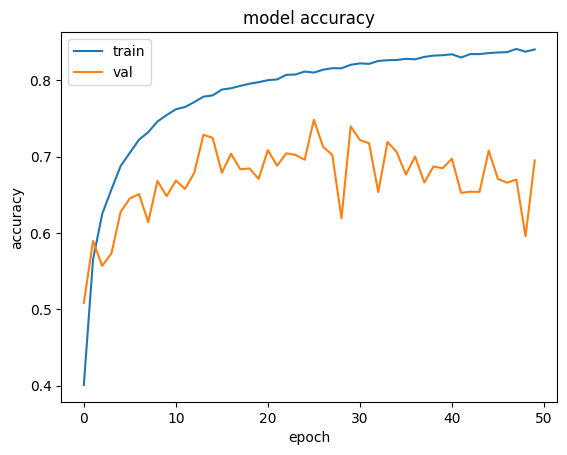

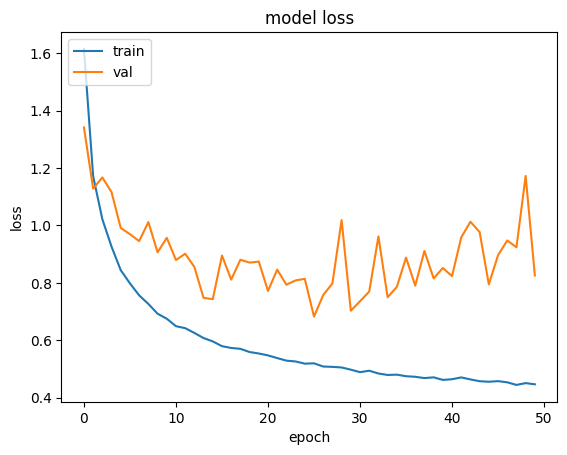

274/274 [==============================] - 0s 2ms/step


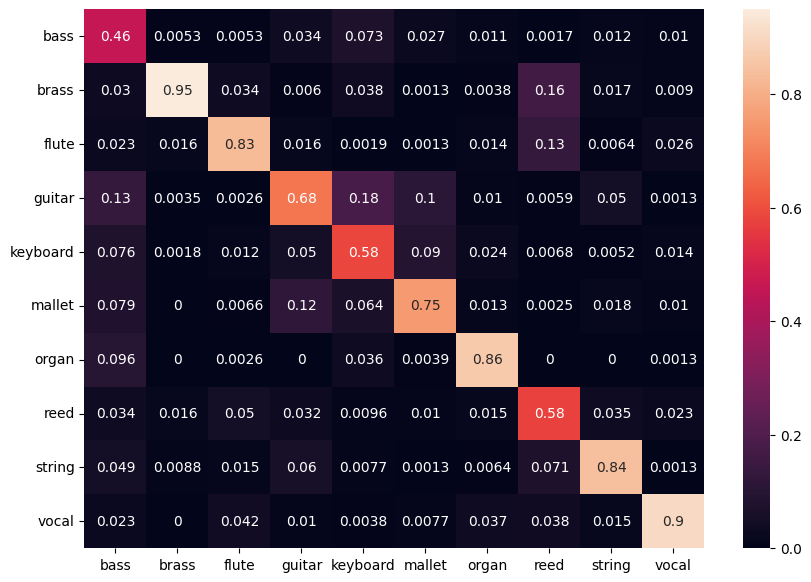

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 13, 32)       320       
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 6, 32)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 63, 6, 64)         18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 6, 64)         36928     
                                                      

2023-05-14 02:28:09.880685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 - 16s - loss: 1.5856 - accuracy: 0.4130 - val_loss: 1.5322 - val_accuracy: 0.4475 - 16s/epoch - 7ms/step
Epoch 2/50
2188/2188 - 15s - loss: 1.2067 - accuracy: 0.5536 - val_loss: 1.2587 - val_accuracy: 0.5471 - 15s/epoch - 7ms/step
Epoch 3/50
2188/2188 - 15s - loss: 1.0706 - accuracy: 0.6001 - val_loss: 1.1820 - val_accuracy: 0.5691 - 15s/epoch - 7ms/step
Epoch 4/50
2188/2188 - 15s - loss: 0.9770 - accuracy: 0.6317 - val_loss: 1.1217 - val_accuracy: 0.5675 - 15s/epoch - 7ms/step
Epoch 5/50
2188/2188 - 15s - loss: 0.9187 - accuracy: 0.6556 - val_loss: 1.2673 - val_accuracy: 0.5249 - 15s/epoch - 7ms/step
Epoch 6/50
2188/2188 - 15s - loss: 0.8619 - accuracy: 0.6777 - val_loss: 1.2614 - val_accuracy: 0.5087 - 15s/epoch - 7ms/step
Epoch 7/50
2188/2188 - 15s - loss: 0.8216 - accuracy: 0.6930 - val_loss: 1.1127 - val_accuracy: 0.5622 - 15s/epoch - 7ms/step
Epoch 8/50
2188/2188 - 15s - loss: 0.7777 - accuracy: 0.7099 - val_loss: 1.0889 - val_accuracy: 0.5881 - 15s/epoch - 7ms/step
Epo

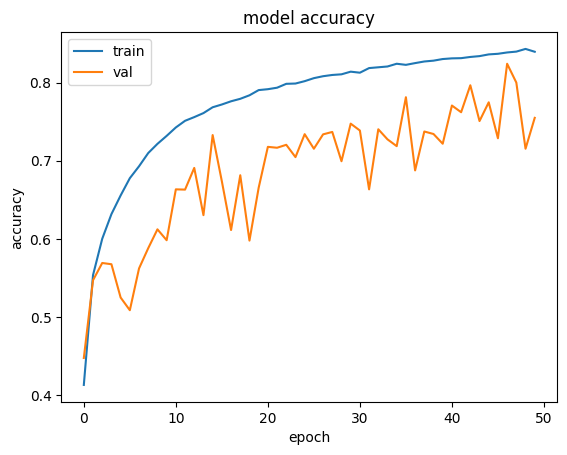

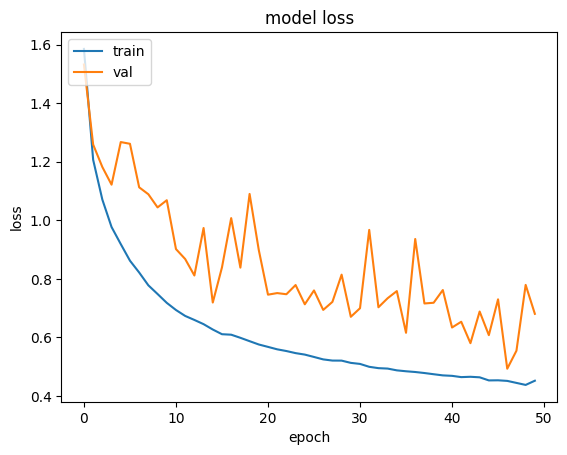

274/274 [==============================] - 0s 2ms/step


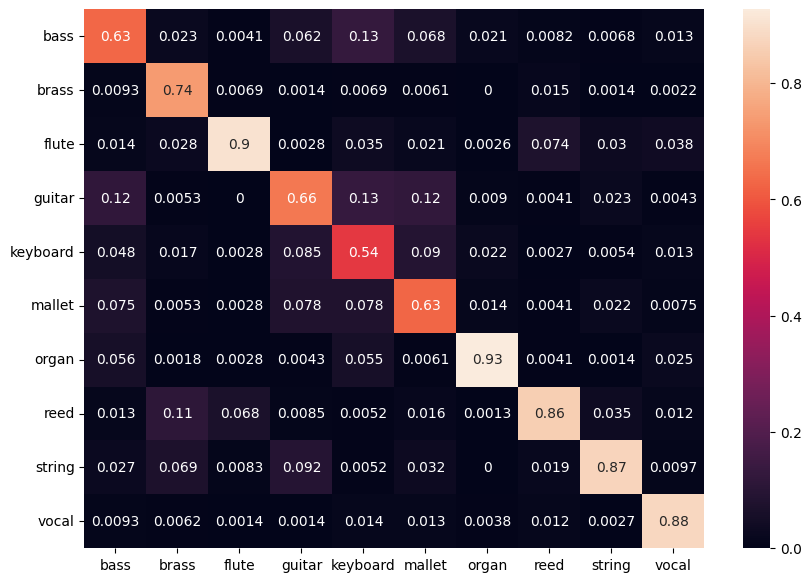

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 13, 32)       320       
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 6, 32)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 6, 64)         18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 63, 6, 64)         36928     
                                                      

2023-05-14 02:41:09.247260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 - 17s - loss: 1.7112 - accuracy: 0.3638 - val_loss: 1.6178 - val_accuracy: 0.4336 - 17s/epoch - 8ms/step
Epoch 2/50
2188/2188 - 15s - loss: 1.3761 - accuracy: 0.4885 - val_loss: 1.5989 - val_accuracy: 0.4530 - 15s/epoch - 7ms/step
Epoch 3/50
2188/2188 - 15s - loss: 1.2088 - accuracy: 0.5488 - val_loss: 1.4733 - val_accuracy: 0.4641 - 15s/epoch - 7ms/step
Epoch 4/50
2188/2188 - 15s - loss: 1.0957 - accuracy: 0.5900 - val_loss: 1.4035 - val_accuracy: 0.5085 - 15s/epoch - 7ms/step
Epoch 5/50
2188/2188 - 15s - loss: 1.0149 - accuracy: 0.6181 - val_loss: 1.3039 - val_accuracy: 0.5317 - 15s/epoch - 7ms/step
Epoch 6/50
2188/2188 - 15s - loss: 0.9565 - accuracy: 0.6418 - val_loss: 1.2282 - val_accuracy: 0.5607 - 15s/epoch - 7ms/step
Epoch 7/50
2188/2188 - 15s - loss: 0.9095 - accuracy: 0.6613 - val_loss: 1.3979 - val_accuracy: 0.4926 - 15s/epoch - 7ms/step
Epoch 8/50
2188/2188 - 15s - loss: 0.8764 - accuracy: 0.6716 - val_loss: 1.3459 - val_accuracy: 0.5043 - 15s/epoch - 7ms/step
Epo

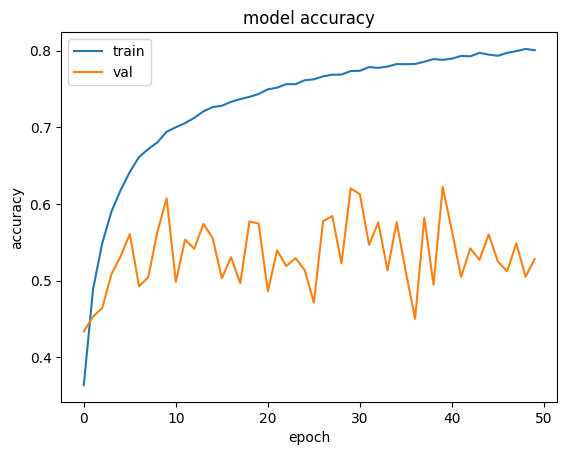

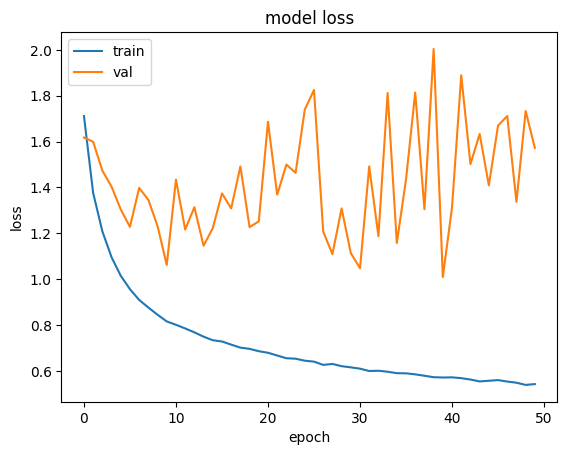

274/274 [==============================] - 0s 2ms/step


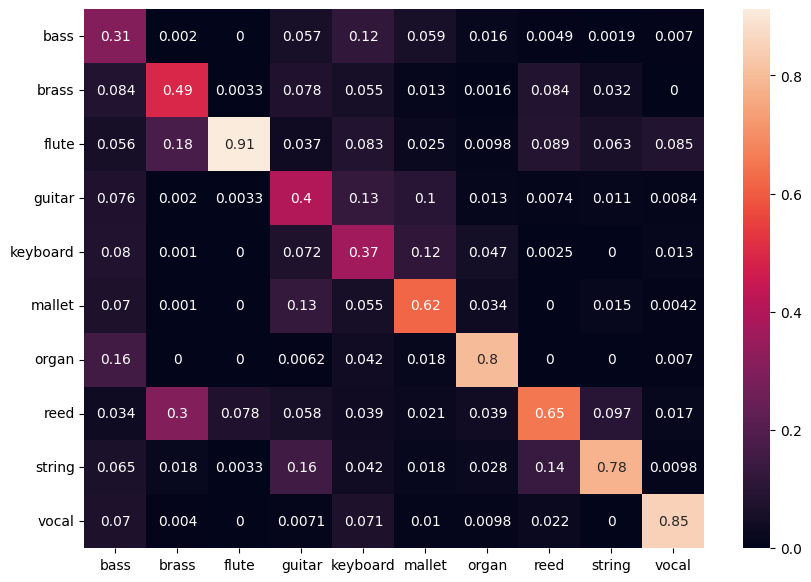

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 13, 32)       320       
                                                                 
 conv2d_16 (Conv2D)          (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 6, 32)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 63, 6, 64)         18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 63, 6, 64)         36928     
                                                      

2023-05-14 02:54:13.653992: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 - 16s - loss: 2.3031 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.1000 - 16s/epoch - 8ms/step
Epoch 2/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0979 - val_loss: 2.3027 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 3/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 4/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 5/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 6/50
2188/2188 - 15s - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 7/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epoch 8/50
2188/2188 - 15s - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3026 - val_accuracy: 0.1000 - 15s/epoch - 7ms/step
Epo

/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

128/128 [==============================] - 0s 2ms/step


/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stenmarken/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

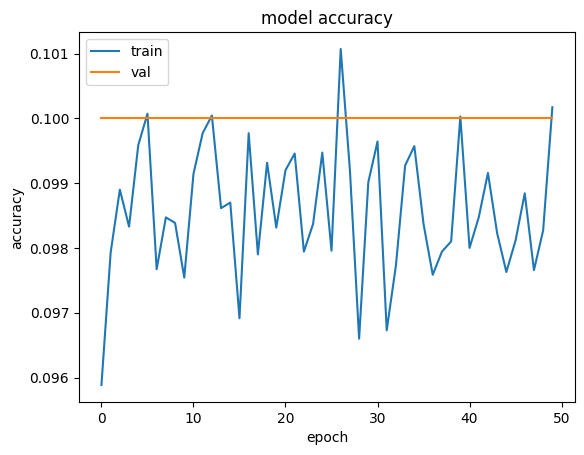

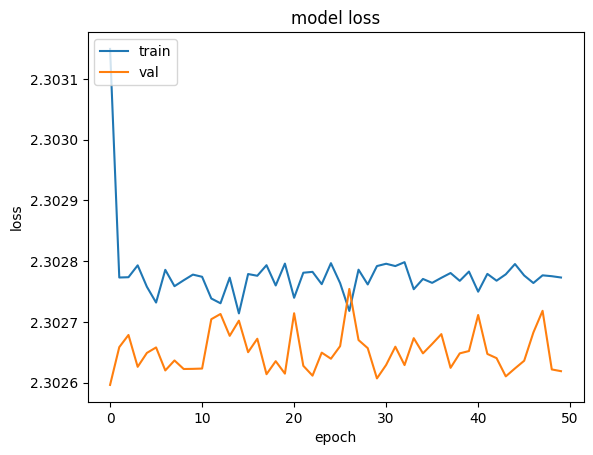

274/274 [==============================] - 0s 2ms/step


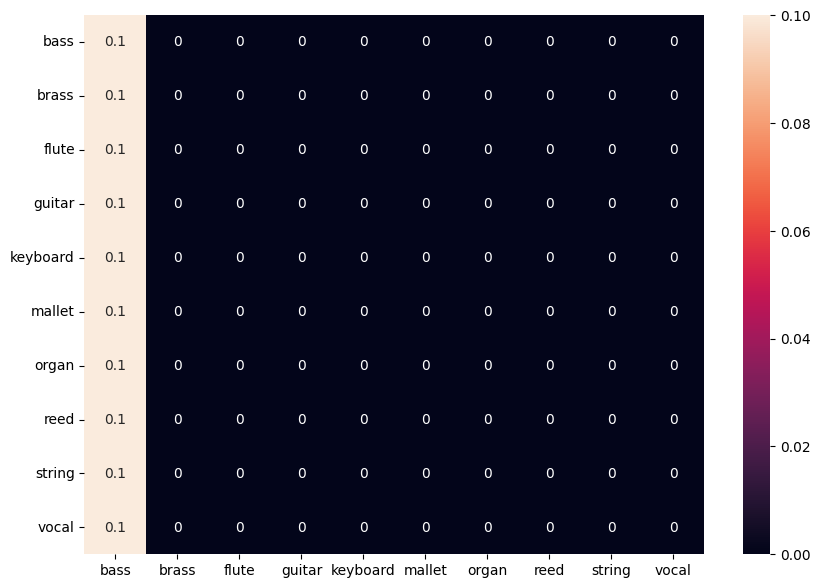

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 126, 13, 32)       320       
                                                                 
 conv2d_21 (Conv2D)          (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 63, 6, 32)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 63, 6, 64)         18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 63, 6, 64)         36928     
                                                      

2023-05-14 03:07:14.400691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 - 17s - loss: 1.6701 - accuracy: 0.3828 - val_loss: 1.4181 - val_accuracy: 0.4618 - 17s/epoch - 8ms/step
Epoch 2/50
2188/2188 - 15s - loss: 1.2677 - accuracy: 0.5299 - val_loss: 1.3481 - val_accuracy: 0.5088 - 15s/epoch - 7ms/step
Epoch 3/50
2188/2188 - 15s - loss: 1.1104 - accuracy: 0.5883 - val_loss: 1.3749 - val_accuracy: 0.4970 - 15s/epoch - 7ms/step
Epoch 4/50
2188/2188 - 15s - loss: 1.0239 - accuracy: 0.6168 - val_loss: 1.3055 - val_accuracy: 0.5315 - 15s/epoch - 7ms/step
Epoch 5/50
2188/2188 - 15s - loss: 0.9577 - accuracy: 0.6406 - val_loss: 1.4528 - val_accuracy: 0.4955 - 15s/epoch - 7ms/step
Epoch 6/50
2188/2188 - 15s - loss: 0.9015 - accuracy: 0.6609 - val_loss: 1.6208 - val_accuracy: 0.4514 - 15s/epoch - 7ms/step
Epoch 7/50
2188/2188 - 15s - loss: 0.8667 - accuracy: 0.6756 - val_loss: 1.3373 - val_accuracy: 0.5442 - 15s/epoch - 7ms/step
Epoch 8/50
2188/2188 - 15s - loss: 0.8350 - accuracy: 0.6856 - val_loss: 1.8469 - val_accuracy: 0.4432 - 15s/epoch - 7ms/step
Epo

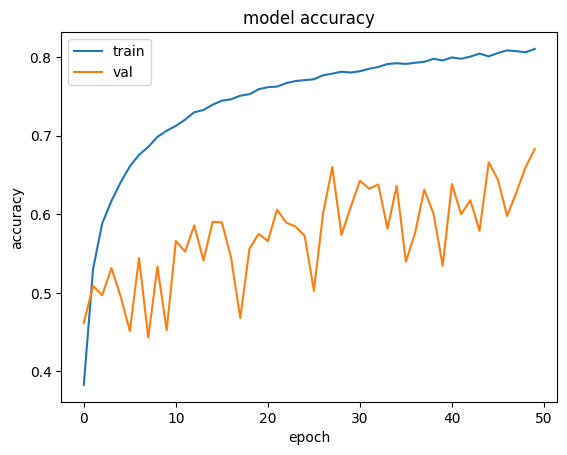

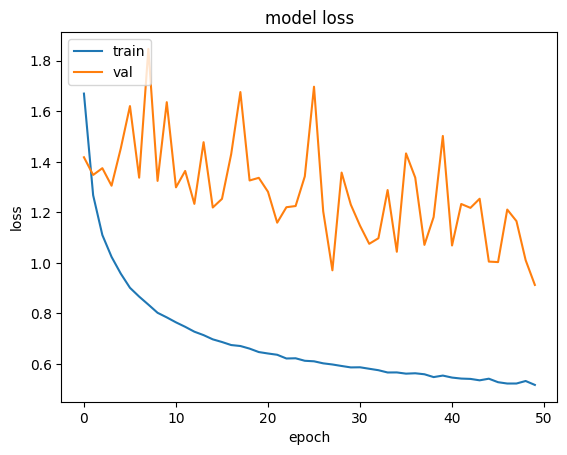

274/274 [==============================] - 0s 2ms/step


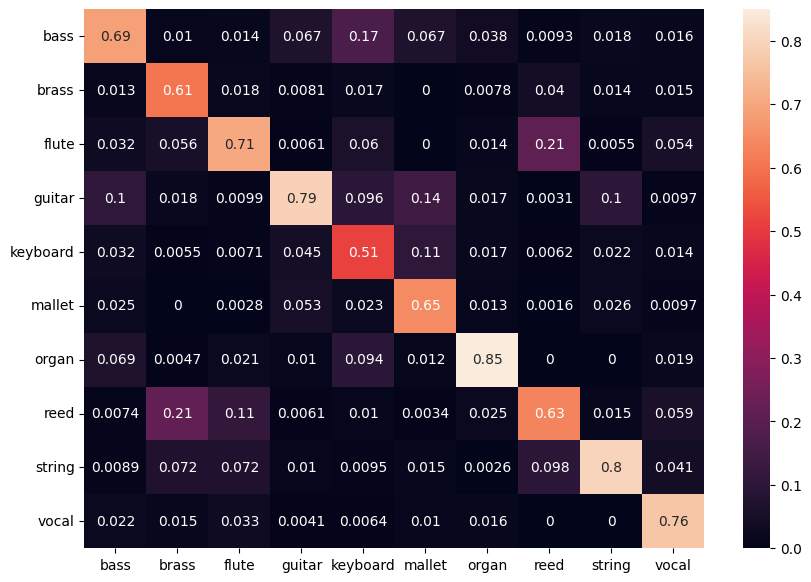

In [21]:
if (global_model_type == 'cnn'):
    print('Start running cnn')
    run_cnn_5_fold_cross_validation()
elif (global_model_type == 'lstm'):
    print('Start running lstm')
    run_lstm_5_fold_cross_validation()
elif (global_model_type == 'tune_cnn'):
    print('Start tuning cnn')
    tune_cnn()
elif (global_model_type == 'tune_lstm'):
    print('Start tuning lstm')
    tune_lstm()